# **Long Short-Term Memory (LSTM)**

---

## **Introduction**

Long Short-Term Memory (LSTM) is a special type of Recurrent Neural Network (RNN) designed to learn long-term dependencies in sequential data. LSTM is well-suited for time series, speech, and EEG signal processing in Brain-Computer Interface (BCI) applications.

**Core ideas of LSTM:**
- Memory Cell  
- Input/Forget/Output Gates  
- Long-Term Dependency Learning  

---

## **Basic Structure**

LSTM addresses the vanishing/exploding gradient problems of standard RNNs through a gated cell mechanism.

### (1) LSTM Cell Equations

At each time step $t$, given input $x_t$, previous hidden state $h_{t-1}$, and cell state $c_{t-1}$:

$$
\begin{align}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \quad \text{(Forget Gate)} \\\\
i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \quad \text{(Input Gate)} \\\\
\tilde{c}_t &= \tanh(W_c \cdot [h_{t-1}, x_t] + b_c) \quad \text{(Candidate Cell State)} \\\\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \quad \text{(New Cell State)} \\\\
o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \quad \text{(Output Gate)} \\\\
h_t &= o_t \odot \tanh(c_t) \quad \text{(New Hidden State)}
\end{align}
$$

Where $\sigma$ is the sigmoid activation, $\tanh$ is the hyperbolic tangent, and $\odot$ is element-wise multiplication.

---

## **LSTM vs. Vanilla RNN**

| Feature | RNN | LSTM |
|--------|-----|------|
| Gradient Flow | Vanishes quickly | Preserved via gates |
| Memory Capacity | Short | Long |
| Structure | Single hidden state | Cell + hidden state |
| Training Stability | Poor | Better |

---

## **Typical LSTM Architecture**

Input Sequence (e.g., EEG, Text)  
→ LSTM Layer(s)  
→ (Optional) Dropout / BatchNorm  
→ Fully Connected Layer  
→ Softmax / Regression Output

---

## **Advantages of LSTM**

| Advantages | Description |
|------------|-------------|
| Long-Term Dependency | Can capture dependencies across long sequences |
| Robust Memory Mechanism | Gates control the flow of information |
| Suitable for Noisy Data | Learns temporal patterns even under noise |
| Flexible Input Length | Handles variable-length sequences naturally |

---

## **Classic LSTM Variants**

| Model Name | Characteristics | Application Scenario |
|------------|-----------------|----------------------|
| Vanilla LSTM | Standard form | Time series modeling |
| Bidirectional LSTM | Reads sequence both forward and backward | EEG decoding, NLP |
| Stacked LSTM | Multiple LSTM layers | Deep sequence learning |
| Attention-based LSTM | Adds attention mechanism | Focus on important timesteps |
| ConvLSTM | Integrates spatial and temporal learning | Spatiotemporal EEG processing |

---

## **Application Scenarios**

LSTM is widely used in:

- Speech Recognition  
- Machine Translation  
- Text Generation  
- EEG-Based Mental State Estimation  
- Sequential Signal Classification  
- Brain State Prediction  

---

## **LSTM in BCI**

### Typical Applications:
- Sequential EEG Classification  
- Cognitive Load Estimation  
- Emotion Recognition  
- Continuous Control Tasks (e.g., driving simulation)  

### Advantages in BCI:
- Captures temporal dependencies in EEG  
- Handles variable sequence lengths from different trials  
- Works well for both raw and feature-level EEG  
- Suitable for real-time online decoding tasks  

---

## **Prerequisites**

- `numpy`  
- `torch`  
- `matplotlib`  
- `scikit-learn`  

---

In practical use, LSTM models often stack multiple layers and combine with dropout or attention to improve performance.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error

from utils import (
    load_data_model,
)

# load train and test data
data_dir = "../data/data_model/sub-jimingda/forward1.npz"
data_list = load_data_model(data_dir)
train_data, train_label = data_list["feature_train"], data_list["steering_train"]
test_data, test_label = data_list["feature_test"], data_list["steering_test"]

In [2]:
# DataLoader
train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32),
                              torch.tensor(train_label, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32),
                             torch.tensor(test_label, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
class EEG_LSTM(nn.Module):
    def __init__(self, input_size=63, hidden_size=128, num_layers=2, dropout=0.3):
        super(EEG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, C, T) -> (B, T, C)
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        out = self.fc(out) 
        return out.squeeze(1)  # (B,)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_LSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 10
train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)

    epoch_loss /= len(train_loader)
    train_loss_list.append(epoch_loss)
    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

Epoch 1/10, Train Loss: 0.3619
Epoch 2/10, Train Loss: 0.1950
Epoch 3/10, Train Loss: 0.0883
Epoch 4/10, Train Loss: 0.0481
Epoch 5/10, Train Loss: 0.0277
Epoch 6/10, Train Loss: 0.0193
Epoch 7/10, Train Loss: 0.0143
Epoch 8/10, Train Loss: 0.0101
Epoch 9/10, Train Loss: 0.0080
Epoch 10/10, Train Loss: 0.0064


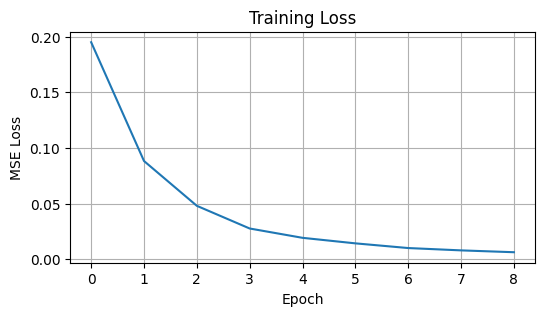

In [9]:
plt.figure(figsize=(6, 3))
plt.plot(train_loss_list[1:])
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

In [12]:
model.eval()
predictions, targets_all = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy()
        predictions.extend(outputs)
        targets_all.extend(targets.numpy())

mse = mean_squared_error(targets_all, predictions)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.0044


In [16]:
# plt.figure(figsize=(10, 4))
# plt.plot(predictions[1000:1500], label="Predicted")
# plt.plot(targets_all[1000:1500], label="True", alpha=0.7)
# plt.legend()
# plt.title("LSTM Prediction")
# plt.xlabel("Sample")
# plt.ylabel("Steering Angle")
# plt.tight_layout()
# plt.show()